# Spectral Masking Implementation Example

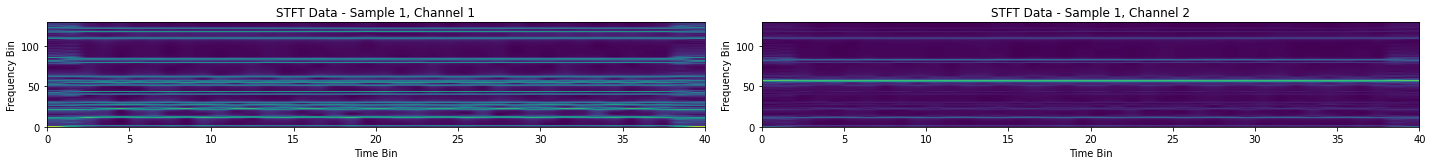

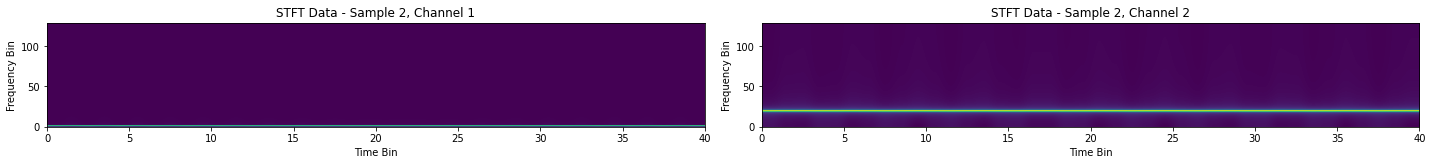

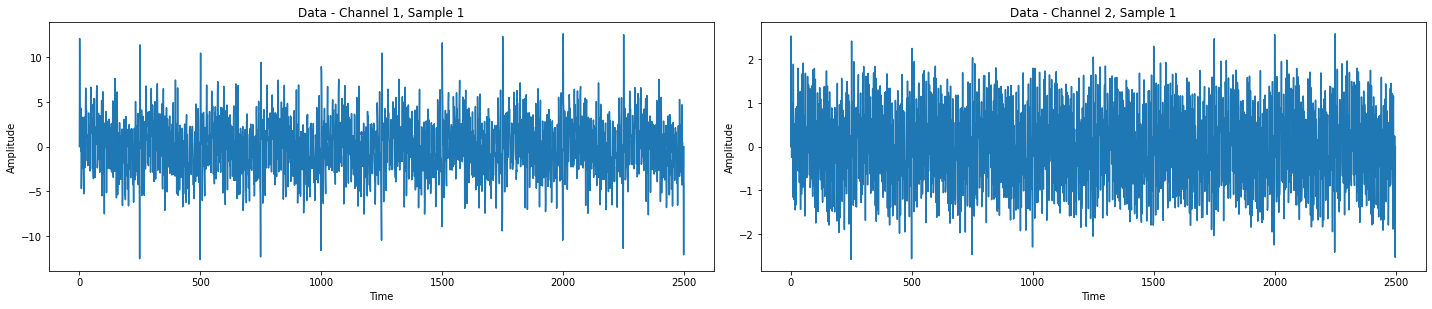

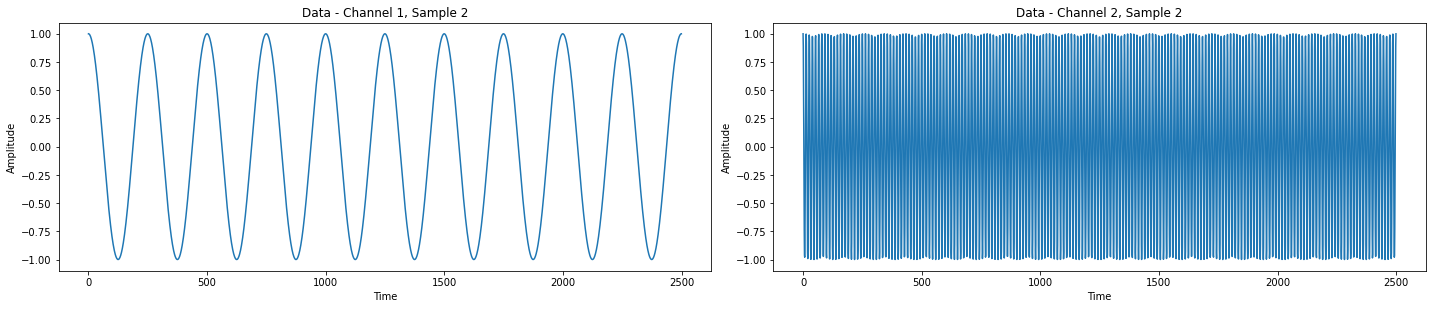

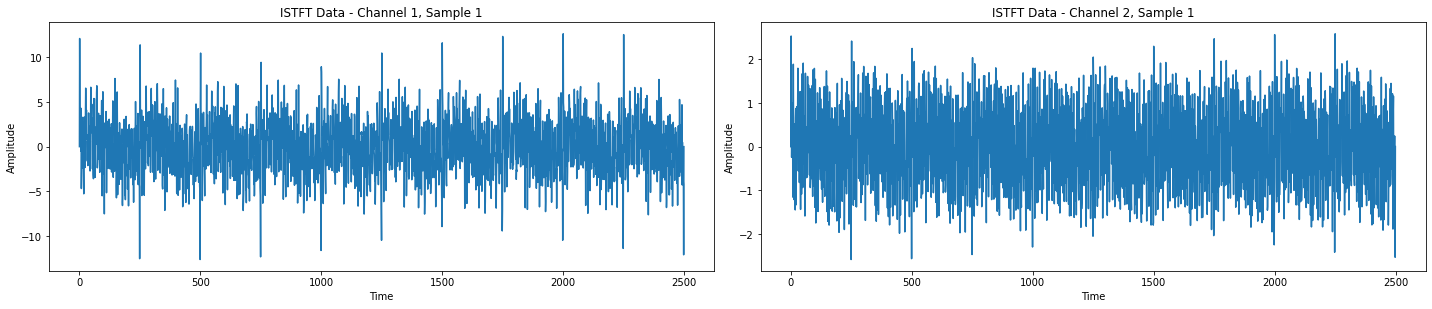

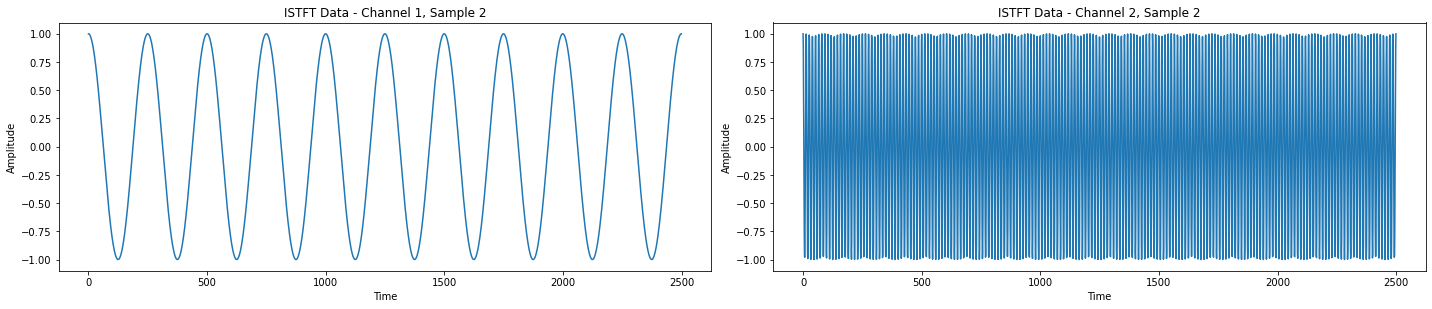

In [50]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_time_series(data, title):
    num_samples, num_channels, _ = data.shape
    for i in range(num_samples):
        plt.figure(figsize=(20, 8))
        for j in range(num_channels):
            plt.subplot(num_samples, num_channels, i * num_channels + j + 1) 
            plt.plot(data[i, j].numpy())
            plt.title(f"{title} - Channel {j+1}, Sample {i+1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()
        
def plot_stft(stft_data, title):
    num_samples, num_channels, freq_bins, time_bins = stft_data.shape

    for i in range(num_samples):
        plt.figure(figsize=(20, 4))
        for j in range(num_channels):
            plt.subplot(num_samples, num_channels, i * num_channels + j + 1)
            plt.imshow(torch.abs(stft_data[i, j]).numpy(), aspect='auto', origin='lower',
                       extent=[0, time_bins, 0, freq_bins])
            plt.title(f"{title} - Sample {i+1}, Channel {j+1}")
            plt.xlabel("Time Bin")
            plt.ylabel("Frequency Bin")
        plt.tight_layout()
        plt.show()



# 가상의 데이터
num_samples = 2
num_channels = 2
num_data_points = 2500
data = torch.zeros(num_samples, num_channels, num_data_points)
import random
for i in range(1,20):
    j = random.randint(1, 128)
    data[0, 0] += torch.sin(torch.linspace(0, 2*torch.pi * j * 10, steps=num_data_points))
    data[0, 1] += (1/i)*torch.sin(torch.linspace(0, 2*torch.pi*j * 10, steps=num_data_points))

    data[1, 0] = torch.cos(torch.linspace(0, 2*(torch.pi) * 10, steps=num_data_points))
    data[1, 1] = torch.cos(torch.linspace(0, 2*(torch.pi*i) * 10, steps=num_data_points))


# STFT 계산 및 시각화
stft_data = torch.stft(data.view(-1, num_data_points), n_fft=256, hop_length=64, return_complex=True)
stft_data = stft_data.view(num_samples, num_channels, stft_data.shape[-2], stft_data.shape[-1])
plot_stft(stft_data, "STFT Data")

istft_data = torch.istft(stft_data.view(-1, stft_data.shape[-2], stft_data.shape[-1]), 
                            n_fft=256, hop_length=64, win_length=128)
istft_data = istft_data.view(num_samples, num_channels, istft_data.shape[-1])  # 형태 조정

_, _, S = istft_data.shape
istft_data_ = copy.deepcopy(data)
istft_data_[:,:, :S] = istft_data

plot_time_series(data, "Data")
plot_time_series(istft_data_, "ISTFT Data")


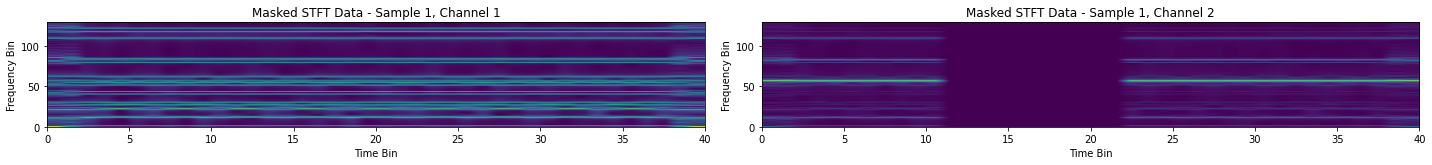

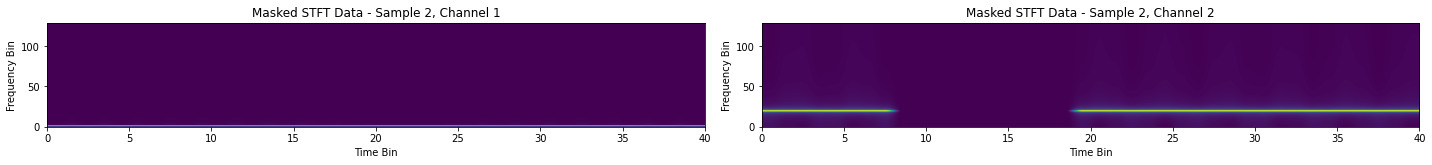

torch.Size([2, 2, 129, 40])


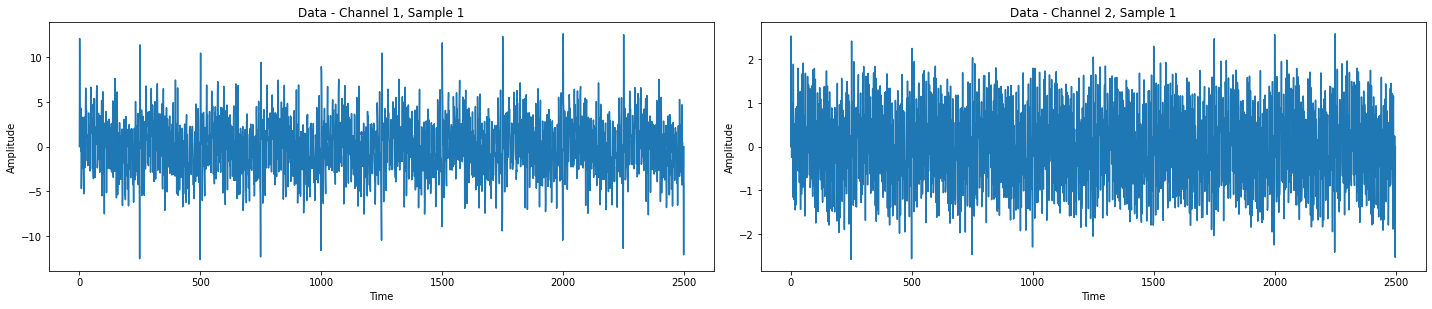

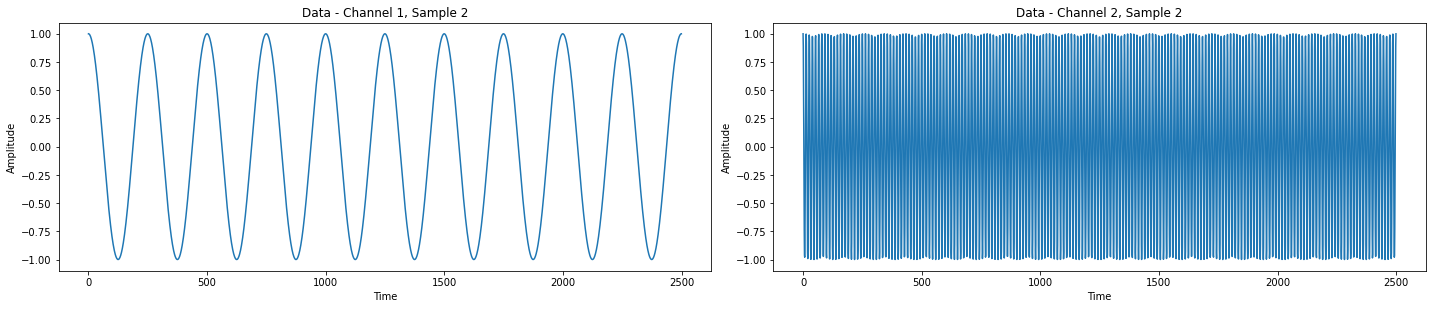

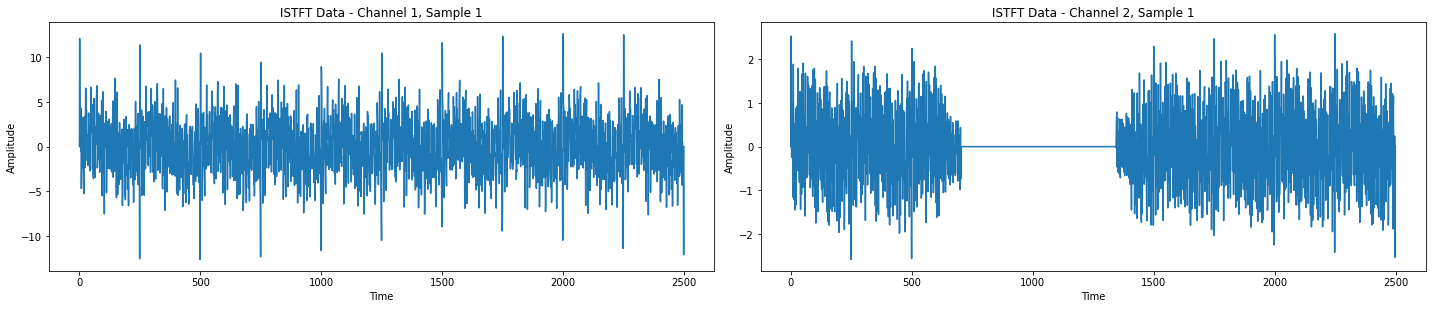

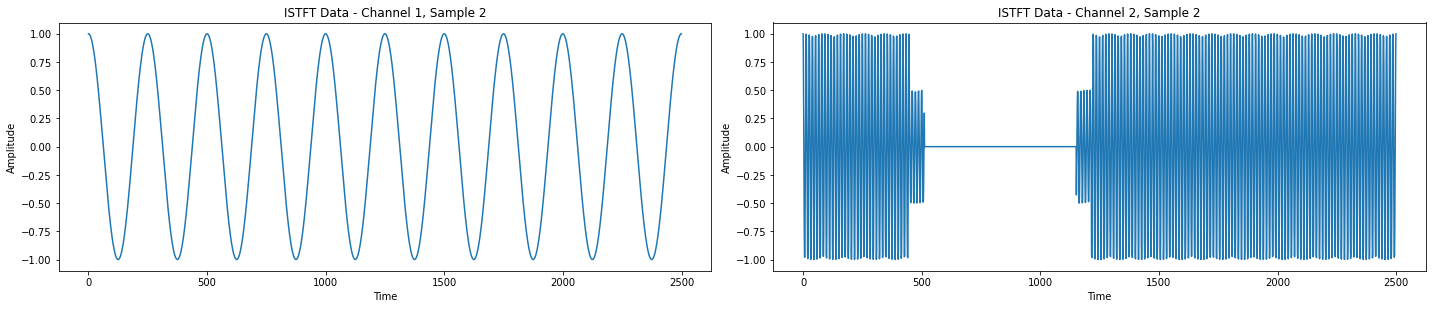

In [53]:
def random_time_masking(stft_data, max_masked_bins=1, mask_size=5):
    masked_stft_data = stft_data.clone()
    num_samples, num_channels, freq_bins, time_bins = stft_data.shape

    for i in range(num_samples):
        for j in range(num_channels):
            num_masked_bins = np.random.randint(0, max_masked_bins + 1)
            masked_bins = np.random.choice(time_bins, num_masked_bins, replace=False)
            for bin_idx in masked_bins:
                bin_range = range(max(0, bin_idx - mask_size), min(time_bins, bin_idx + mask_size + 1))
                masked_stft_data[i, j, :, bin_range] = 0.0

    return masked_stft_data

masked_stft_data = random_time_masking(stft_data)
plot_stft(masked_stft_data, "Masked STFT Data")
print(masked_stft_data.shape)

istft_data = torch.istft(masked_stft_data.view(-1, masked_stft_data.shape[-2], masked_stft_data.shape[-1]), 
                            n_fft=256, hop_length=64, win_length=128)
istft_data = istft_data.view(num_samples, num_channels, istft_data.shape[-1])  # 형태 조정

_, _, S  = istft_data.shape
istft_data_ = copy.deepcopy(data)
istft_data_[:, :, :S] = istft_data

plot_time_series(data, "Data")
plot_time_series(istft_data_, "ISTFT Data")

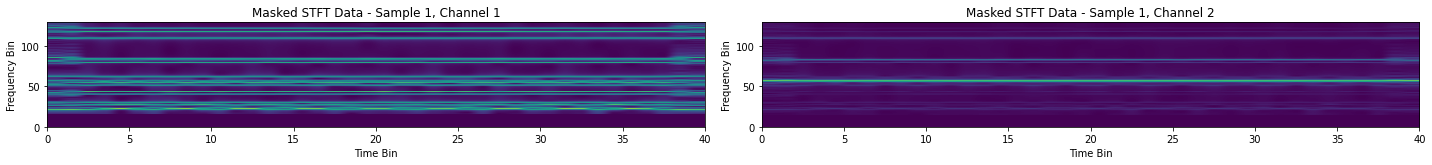

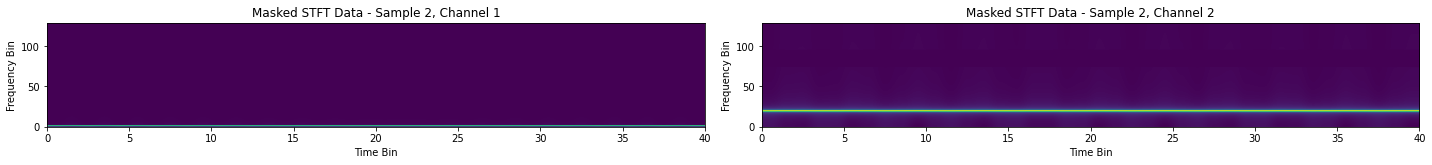

torch.Size([2, 2, 129, 40])


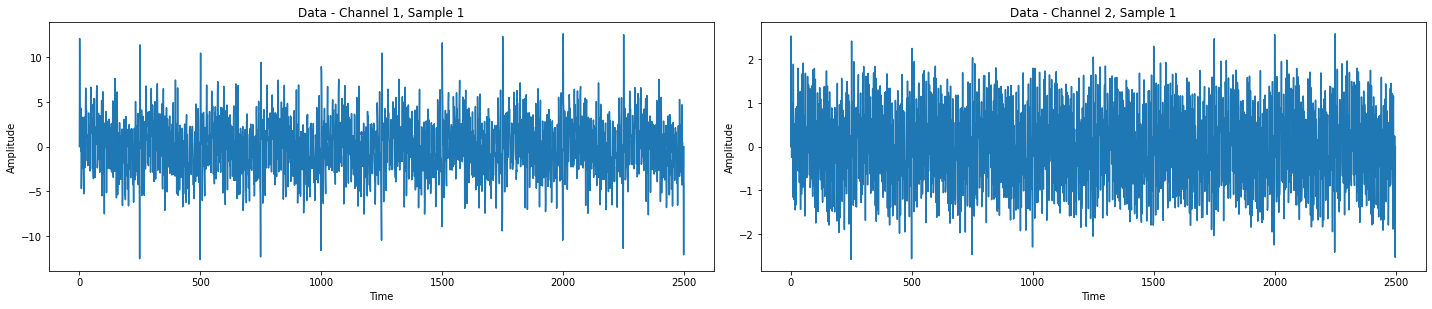

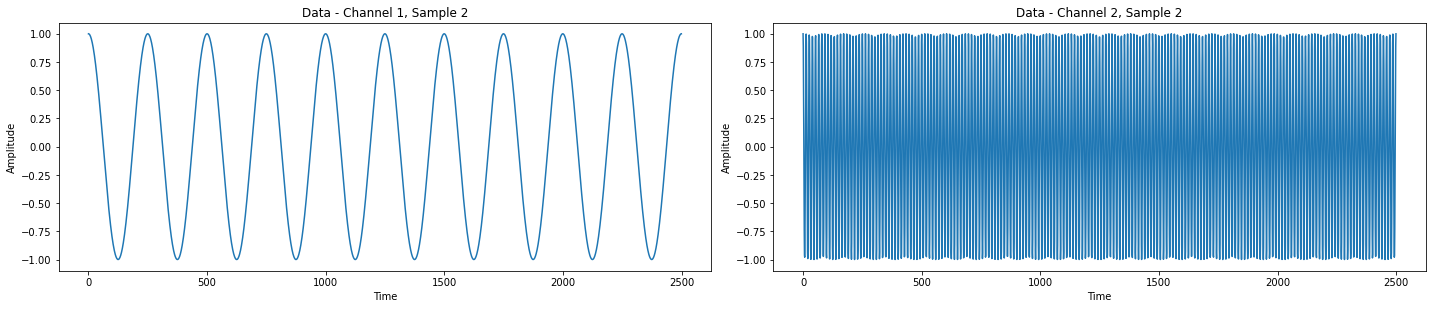

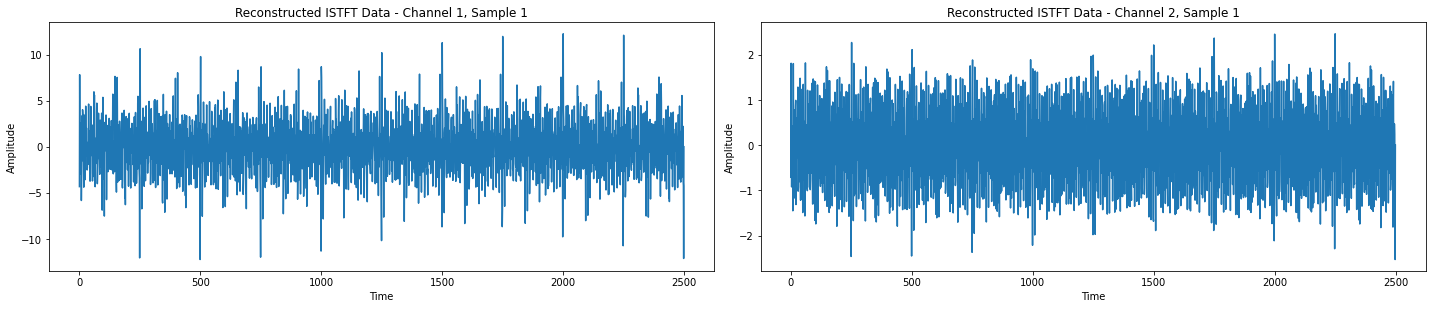

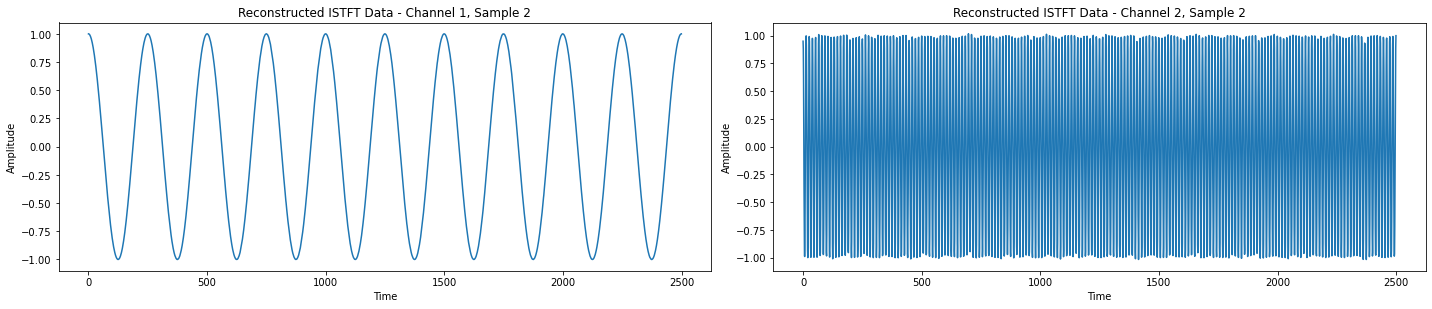

In [58]:
def random_frequency_masking(stft_data, max_masked_bins=2, mask_size=10):
    masked_stft_data = stft_data.clone()
    num_samples, num_channels, freq_bins, time_bins = stft_data.shape

    for i in range(num_samples):
        for j in range(num_channels):
            num_masked_bins = np.random.randint(1, max_masked_bins + 1)
            masked_bins = np.random.choice(freq_bins, num_masked_bins, replace=False)
            for bin_idx in masked_bins:
                bin_range = range(max(0, bin_idx - mask_size), min(freq_bins, bin_idx + mask_size + 1))
                masked_stft_data[i, j, bin_range, :] = 0.0

    return masked_stft_data


# 주파수 축 마스킹
masked_stft_data = random_frequency_masking(stft_data)
plot_stft(masked_stft_data, "Masked STFT Data")
print(masked_stft_data.shape)

# 마스킹된 STFT 데이터를 ISTFT로 변환하여 복원
istft_data = torch.istft(masked_stft_data.view(-1, masked_stft_data.shape[-2], masked_stft_data.shape[-1]), 
                            n_fft=256, hop_length=64, win_length=256)

istft_data = istft_data.view(num_samples, num_channels, istft_data.shape[-1])

_, _, S  = istft_data.shape
istft_data_ = copy.deepcopy(data)
istft_data_[:, :, :S] = istft_data

plot_time_series(data, "Data")
plot_time_series(istft_data_, "Reconstructed ISTFT Data")
